# Teste de Influência de SNR e ETA no desempenho do classificador

No último teste, vimos que há uma grande quantidade de autovalores que podem ser utilizados para ajudar na classificação, não apenas os três maiores. Uma coisa que chamou muito a atenção é que a SNR nunca apareceu nas primeiras colocações de feature importance. A hipótese é a de que, como a energia E do Hassan e a matriz R do Kapetanovic usam a SNR em seus cálculos, então esse valor está implícito nas features, fazendo o valor da SNR ser redundante. ETA tb não apareceu nas melhores colocações, então vamos fazer um teste com essa feature tb.

Além disso, além de simplesmente remover a SNR do espaço das features, também vamos testar se a gnt pode usar só SNR de 5 em 5 dB pra treinar o classificador. O desejado é que ele continue robusto e acertando a classificação dos dados que estão entre essas SNRs.

Os testes anteriores mostraram que a gnt deve excluir os 100 menores autovalores pra acurácia ser a mais alta possível. É claro que essa quantidade varia conforme a quantidade de usuários conectados, mas fica sempre ao redor de 100 autovalores ignorados. Então pra arredondar eu vou ignorar 103 pra sobrar exatamente os 25 maiores. Daria pra ter arrendondado pra 30, mas parece que ignorar menos de 100 autovalores não é mto bom, melhor ignorar um pouco mais.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

In [2]:
#DEFININDO ALGUNS PARÂMETROS DO GRÁFICO
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
params = {
    'figure.figsize': [10, 2.5], 
    'axes.labelsize': 11,
    'axes.titlesize':12, 
    'font.size': 11,
    'legend.fontsize': 9, 
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8,
    'axes.axisbelow': True
}
plt.rcParams.update(params)

### Definição de Funções

In [3]:
def obterDados(qtdUsuarios, qtdAntenas, qtdSimbolos, droparFeatures=None):
    
    # CONSTRUO O CAMINHO
    caminhoCSV = "../../CSV/dataset_"+str(qtdUsuarios)+"usuarios_"+str(qtdAntenas)+"antenas_"+str(qtdSimbolos)+"simbolos_autovalores_completos.csv"    
    
    # ABRO O CSV
    datasetCSV = pd.read_csv(caminhoCSV)
    
     # DROPANDO AS FEATURES DESEJADAS
    if droparFeatures != None:
        datasetCSV = datasetCSV.drop(droparFeatures, axis=1)

    # SEPARANDO DATA, TARGET, POTENCIA DO ESPIAO E SNR DE CADA DADO
    arrayData      = datasetCSV[datasetCSV.columns[:-2]].to_numpy()
    arrayTarget    = datasetCSV[datasetCSV.columns[-1]].to_numpy()
    
    # RETORNO OS DADOS
    return arrayData, arrayTarget

In [4]:
def treinarEClassificar(xTrain, xTest, yTrain, classificador):
    
    # INSTANCIANDO O CLASSIFICADOR
    objClassificador = eval(classificador)
    
    # TREINANDO
    objClassificador.fit(xTrain, yTrain)
    
    # PREDIZENDO
    yPred = objClassificador.predict(xTest)
    
    # RETORNANDO A ACURACIA
    return yPred

In [5]:
def rodarKFold(arrayData, arrayTarget, qtdFolders, classificador):
    
    somaMatrizesConfusao = np.zeros((2,2))
    
    # KFOLD
    objKFold = KFold(n_splits=qtdFolders, shuffle=True)
    for arrayIndexesTreinamento, arrayIndexesTeste in objKFold.split(arrayData):
        
        # TREINO E TESTE
        xTrain, xTest, yTrain, yTest = arrayData[arrayIndexesTreinamento], arrayData[arrayIndexesTeste], arrayTarget[arrayIndexesTreinamento], arrayTarget[arrayIndexesTeste]
        
        # CLASSIFICACAO
        yPred = treinarEClassificar(xTrain, xTest, yTrain, classificador)
        
        # AGREGO NA CONFUSION MATRIX
        somaMatrizesConfusao += confusion_matrix(yTest, yPred)
    
    return somaMatrizesConfusao

In [6]:
def obterMetricas(matrizConfusao):
    
    acuracia  = 0.0
    precisao  = 0.0
    revocacao = 0.0
    
    if np.sum(matrizConfusao) != 0:
        acuracia  = (matrizConfusao[0][0]+matrizConfusao[1][1])/np.sum(matrizConfusao)
    if (matrizConfusao[1][1] + matrizConfusao[0][1]) != 0:
        precisao  = matrizConfusao[1][1]/(matrizConfusao[1][1] + matrizConfusao[0][1])
    if (matrizConfusao[1][1] + matrizConfusao[1][0]) != 0:
        revocacao = matrizConfusao[1][1]/(matrizConfusao[1][1] + matrizConfusao[1][0])
    
    return acuracia, precisao, revocacao

In [7]:
def printarComparacaoMatrizesComESemFeature(feature, matrizConfusaoSemFeatureDesejada, matrizConfusaoComFeatureDesejada, qtdUsuarios, qtdAntenas, qtdSimbolos, qtdAutovaloresDesejados, acuraciaSemFeatureDesejada, precisaoSemFeatureDesejada, revocacaoSemFeatureDesejada, acuraciaComFeatureDesejada, precisaoComFeatureDesejada, revocacaoComFeatureDesejada):
    
    # MONTANDO O TITULO DA FIGURA
    titulo  = "Usuários: " + str(qtdUsuarios) + " - Antenas: " + str(qtdAntenas) + " - Símbolos: " + str(qtdSimbolos) + " - Autovalores: " + str(qtdAutovaloresDesejados) + "\n"
    
    # CRIANDO A MATRIZ DE CONFUSAO QUANDO A FEATURE DESEJADA NAO FOI UTILIZADA COMO FEATURE
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(matrizConfusaoSemFeatureDesejada, cmap="gray")
    for (j,i), total in np.ndenumerate(matrizConfusaoSemFeatureDesejada):
        axs[0].text(i, j, int(total), ha="center", va="center", color="#e6005c", size=15)
    axs[0].set_title("SEM " + feature + "\nAcurácia: " + str(acuraciaSemFeatureDesejada)[:7] + "\nPrecisão: " + str(precisaoSemFeatureDesejada)[:7] + "\nRevocação: " + str(revocacaoSemFeatureDesejada)[:7])
    axs[0].set_xlabel("Predito")
    axs[0].set_ylabel("Real")
    axs[0].set_xticklabels([])
    axs[0].set_yticklabels([])
    
    # CRIANDO A MATRIZ DE CONFUSAO QUANDO A FEATURE DESEJADA FOI SIM UTILIZADA COMO FEATURE
    axs[1].imshow(matrizConfusaoComFeatureDesejada, cmap="gray")
    for (j,i), total in np.ndenumerate(matrizConfusaoComFeatureDesejada):
        axs[1].text(i, j, int(total), ha="center", va="center", color="#e6005c", size=15)
    axs[1].set_title("COM " + feature + "\nAcurácia: " + str(acuraciaComFeatureDesejada)[:7] + "\nPrecisão: " + str(precisaoComFeatureDesejada)[:7] + "\nRevocação: " + str(revocacaoComFeatureDesejada)[:7])
    axs[1].set_xlabel("Predito")
    axs[1].set_ylabel("Real")
    axs[1].set_xticklabels([])
    axs[1].set_yticklabels([])
    
    # PRINTANDO
    plt.suptitle(titulo, y=1.3)
    plt.show()

In [18]:
def obterDatasetsDiferentesSNRs(qtdUsuarios, qtdAntenas, qtdSimbolos, autovaloresIndesejados):    
    # DE CARA JA DA PRA MONTAR O DATASET COMPLETO, COM TODAS AS SNRS. AINDA NAO VOU REMOVER A SNR DO ESPACO DE FEATURES PQ VOU PRECISAR DELA PRA MONTAR OS OUTROS DATASETS, MAS O ETA JA DA PRA EXCLUIR
    dataSNRsCompletas, targetSNRsCompletas = obterDados(qtdUsuarios, qtdAntenas, qtdSimbolos, ["eta"]+autovaloresIndesejados)

    # MONTANDO OS OUTROS DOIS DATASETS
    dataSNRsTreinamento   = []
    dataSNRsTeste         = []
    targetSNRsTreinamento = []
    targetSNRsTeste       = []

    for i in range(len(targetSNRsCompletas)):

        if dataSNRsCompletas[i][0] % 5 == 0:
            dataSNRsTreinamento.append(dataSNRsCompletas[i])
            targetSNRsTreinamento.append(targetSNRsCompletas[i])
        else:
            dataSNRsTeste.append(dataSNRsCompletas[i])
            targetSNRsTeste.append(targetSNRsCompletas[i])

    # PASSANDO PRA NUMPY
    dataSNRsTreinamento   = np.array(dataSNRsTreinamento)
    dataSNRsTeste         = np.array(dataSNRsTeste)
    targetSNRsTreinamento = np.array(targetSNRsTreinamento)
    targetSNRsTeste       = np.array(targetSNRsTeste)

    # GARANTINDO QUE A QTD DE DADOS DO DATASET DE TESTE + A QTD DO DE TESTE E IGUAL A DO DATASET TOTAL
    assert dataSNRsTeste.shape[0] + dataSNRsTreinamento.shape[0] == dataSNRsCompletas.shape[0], "ALGO DE ERRADO COM A DIMENSIONALIDADE DOS DATASETS!"

    # AGORA A GNT DA UM SHUFFLE E LIMITA A QUANTIDADE DE DADOS PELO MENOR DATASET
    dataSNRsCompletas,   targetSNRsCompletas   = shuffle(dataSNRsCompletas,   targetSNRsCompletas)
    dataSNRsTreinamento, targetSNRsTreinamento = shuffle(dataSNRsTreinamento, targetSNRsTreinamento)
    dataSNRsTeste,       targetSNRsTeste       = shuffle(dataSNRsTeste,       targetSNRsTeste)

    # LIMITANDO O TAMANHO E AO MESMO TEMPO REMOVENDO A SNR DO ESPACO DE FEATURES
    tamanhoMaximo = len(targetSNRsTreinamento)
    dataSNRsTreinamento   = dataSNRsTreinamento[:tamanhoMaximo, 1:]
    dataSNRsTeste         = dataSNRsTeste[:tamanhoMaximo, 1:]
    dataSNRsCompletas     = dataSNRsCompletas[:tamanhoMaximo, 1:]
    targetSNRsTreinamento = targetSNRsTreinamento[:tamanhoMaximo]
    targetSNRsTeste       = targetSNRsTeste[:tamanhoMaximo]
    targetSNRsCompletas   = targetSNRsCompletas[:tamanhoMaximo]

    # VAMO QUE VAMO
    return dataSNRsTreinamento, dataSNRsTeste, dataSNRsCompletas, targetSNRsTreinamento, targetSNRsTeste, targetSNRsCompletas

In [31]:
def printarComparacaoTreinamentoParcialECompleto(somaMatrizesConfusaoTreinamentoParcial, somaMatrizesConfusaoTreinamentoCompleto, qtdUsuarios, qtdAntenas, qtdSimbolos, qtdAutovaloresDesejados):
    acuraciaTreinamentoParcial, precisaoTreinamentoParcial, revocacaoTreinamentoParcial = obterMetricas(somaMatrizesConfusaoTreinamentoParcial)
    acuraciaTreinamentoCompleto, precisaoTreinamentoCompleto, revocacaoTreinamentoCompleto = obterMetricas(somaMatrizesConfusaoTreinamentoCompleto)

    # MONTANDO O TITULO DA FIGURA
    titulo  = "Usuários: " + str(qtdUsuarios) + " - Antenas: " + str(qtdAntenas) + " - Símbolos: " + str(qtdSimbolos) + " - Features: E + " + str(qtdAutovaloresDesejados) + " autovalores\n"

    # CRIANDO A MATRIZ DE CONFUSAO QUANDO NO CASO DE TREINAMENTO PARCIAL
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(somaMatrizesConfusaoTreinamentoParcial, cmap="gray")
    for (j,i), total in np.ndenumerate(somaMatrizesConfusaoTreinamentoParcial):
        axs[0].text(i, j, int(total), ha="center", va="center", color="#e6005c", size=15)
    axs[0].set_title("Treinamento Parcial\nAcurácia: " + str(acuraciaTreinamentoParcial)[:7] + "\nPrecisão: " + str(precisaoTreinamentoParcial)[:7] + "\nRevocação: " + str(revocacaoTreinamentoParcial)[:7])
    axs[0].set_xlabel("Predito")
    axs[0].set_ylabel("Real")
    axs[0].set_xticklabels([])
    axs[0].set_yticklabels([])

    # CRIANDO A MATRIZ DE CONFUSAO QUANDO A FEATURE DESEJADA FOI SIM UTILIZADA COMO FEATURE
    axs[1].imshow(somaMatrizesConfusaoTreinamentoCompleto, cmap="gray")
    for (j,i), total in np.ndenumerate(somaMatrizesConfusaoTreinamentoCompleto):
        axs[1].text(i, j, int(total), ha="center", va="center", color="#e6005c", size=15)
    axs[1].set_title("Treinamento Completo\nAcurácia: " + str(acuraciaTreinamentoCompleto)[:7] + "\nPrecisão: " + str(precisaoTreinamentoCompleto)[:7] + "\nRevocação: " + str(revocacaoTreinamentoCompleto)[:7])
    axs[1].set_xlabel("Predito")
    axs[1].set_ylabel("Real")
    axs[1].set_xticklabels([])
    axs[1].set_yticklabels([])

    # PRINTANDO
    plt.suptitle(titulo, y=1.3)
    plt.show()

### Parâmetros Iniciais

In [29]:
# TEMOS DATASETES COM QUAIS QTDs DE USUARIOS?
rangeQtdUsuarios = [1,2,4,8,256] #[1,2,4,8,16,32,64,128,256]

# OUTROS PARAMETROS DOS DATASETS PRA MONTAR O CAMINHO DO CSV
qtdAntenas  = 256
qtdSimbolos = 128

# CLASSIFICADOR PRA USAR NA AVALIACAO
classificador = "RandomForestClassifier(n_estimators=10, n_jobs=-1)"

# QTD DE ITERACOES DO K FOLD    
qtdFolders = 5

# AUTOVALORES IGNORADOS (AI E SO CONCATENAR COM O DROPARFEATURES)
qtdAutovaloresDesejados = 25
autovaloresIndesejados  = str(np.arange(qtdAutovaloresDesejados+1,129)).replace("\n", "").replace("[", "").replace("]", "").replace("   ", " ").replace("  ", " ").replace(" ", " autovalor").split(" ")[1:]

# ARQUIVO DE SALVAR OS RESULTADOS
#arquivoSalvar = "../../Resultados/featureImportanceAutovalores"+str(time())+".txt"

## Teste de classificação com e sem SNR como feature

Primeiro vamos fazer um KFold com a SNR como feature pra ver como ficam as métricas. Em seguida a gnt tira a SNR da jogada e calcula as mesmas métricas. Em todos os casos, E e eta serão features.

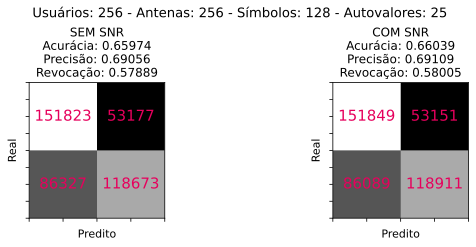

In [10]:
# PARA CADA QTD DE USUARIOS
for qtdUsuariosAtual in rangeQtdUsuarios:

    # OBTEMOS DATA E TARGET DO DATASET - VAMOS IGNORAR OS AUTOVALORES DE 26 ATE 128, VAI SOBRAR SO SNR, E, ETA, AUTOVALOR1, ..., AUTOVALOR25.
    arrayData, arrayTarget = obterDados(qtdUsuariosAtual, qtdAntenas, qtdSimbolos, autovaloresIndesejados)
    
    # RODAMOS O KFOLD COM A SNR COMO FEATURE E RECEBEMOS A SOMA DAS MATRIZES DE CONFUSAO DE CADA ITERACAO
    somaMatrizesConfusaoComSNR                      = rodarKFold(arrayData, arrayTarget, qtdFolders, classificador)
    acuraciaComSNR, precisaoComSNR, revocacaoComSNR = obterMetricas(somaMatrizesConfusaoComSNR)
    
    # AGORA NOS VAMOS REMOVER A SNR, BASTA TIRAR A COLUNA 0 DO ARRAYDATA
    arrayData = np.delete(arrayData, 0, axis=1)
    
    # REPETIMOS O KFOLD, DESSA VEZ SEM A SNR COMO FEATURE
    somaMatrizesConfusaoSemSNR                      = rodarKFold(arrayData, arrayTarget, qtdFolders, classificador)
    acuraciaSemSNR, precisaoSemSNR, revocacaoSemSNR = obterMetricas(somaMatrizesConfusaoSemSNR)
    
    #EXIBINDO A COMPARACAO
    printarComparacaoMatrizesComESemFeature("SNR", somaMatrizesConfusaoSemSNR, somaMatrizesConfusaoComSNR, qtdUsuariosAtual, qtdAntenas, qtdSimbolos, qtdAutovaloresDesejados, acuraciaSemSNR, precisaoSemSNR, revocacaoSemSNR, acuraciaComSNR, precisaoComSNR, revocacaoComSNR)

## Teste de classificação com e sem ETA como feature

Agora chegou a vez de testar a influência do eta. Primeiro vamos fazer um KFold com ETa como feature pra ver como ficam as métricas. Em seguida a gnt tira ETA da jogada e calcula as mesmas métricas. Em todos os casos, E e SNR serão features.

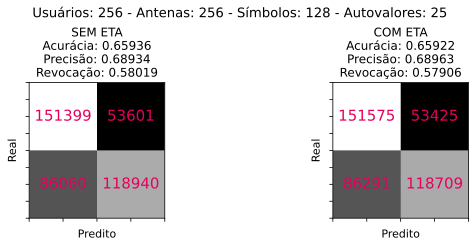

In [11]:
# PARA CADA QTD DE USUARIOS
for qtdUsuariosAtual in rangeQtdUsuarios:

    # OBTEMOS DATA E TARGET DO DATASET - VAMOS IGNORAR OS AUTOVALORES DE 26 ATE 128, VAI SOBRAR SO SNR, E, ETA, AUTOVALOR1, ..., AUTOVALOR25.
    arrayData, arrayTarget = obterDados(qtdUsuariosAtual, qtdAntenas, qtdSimbolos, autovaloresIndesejados)
    
    # RODAMOS O KFOLD COM O ETA COMO FEATURE E RECEBEMOS A SOMA DAS MATRIZES DE CONFUSAO DE CADA ITERACAO
    somaMatrizesConfusaoComETA                      = rodarKFold(arrayData, arrayTarget, qtdFolders, classificador)
    acuraciaComETA, precisaoComETA, revocacaoComETA = obterMetricas(somaMatrizesConfusaoComETA)
    
    # AGORA NOS VAMOS REMOVER O ETA, BASTA TIRAR A COLUNA 2 DO ARRAYDATA
    arrayData = np.delete(arrayData, 2, axis=1)
    
    # REPETIMOS O KFOLD, DESSA VEZ SEM O ETA COMO FEATURE
    somaMatrizesConfusaoSemETA                      = rodarKFold(arrayData, arrayTarget, qtdFolders, classificador)
    acuraciaSemETA, precisaoSemETA, revocacaoSemETA = obterMetricas(somaMatrizesConfusaoSemETA)
    
    #EXIBINDO A COMPARACAO
    printarComparacaoMatrizesComESemFeature("ETA", somaMatrizesConfusaoSemETA, somaMatrizesConfusaoComETA, qtdUsuariosAtual, qtdAntenas, qtdSimbolos, qtdAutovaloresDesejados, acuraciaSemETA, precisaoSemETA, revocacaoSemETA, acuraciaComETA, precisaoComETA, revocacaoComETA)

## Treinamento feito apenas com SNRs de 5 em 5 dB

A metodologia será a seguinte, vou criar 3 datasets:

dataset_SNRsTreinamento -> apenas os dados com SNRs múltiplas de 5

dataset_SNRsTeste -> apenas as SNRs restantes (não múltiplas de 5)

dataset_SNRsCompletas -> todos os valores de SNR

Depois, vou embaralhar os datasets e limitar o tamanho deles pelo mais curto. Se isso não for feito, o dataset_SNRsTreinamento vai ser muito menor que os demais, e desse jeito o treinamento vai ser muito menor que o experimento com todas as SNRs. Logo, o resultado será injusto. Se a gnt quer comparar as duas situações (treinamento de 5 em 5 versus treinamento completo), os datasets têm que ter o mesmo tamanho.

Depois que os 3 estiverem com o mesmo tamanho eu vou rodar 2 KFolds. Em um deles, os dados de treinamento e teste vão vir de datasets diferentes (os dois primeiros explicados ali em cima). No segundo KFold, vamos fazer nossa referência. Vamos treinar e testar com todas as SNRs. Nesse último KFold, vamos usar somente o último dataset.

As features serão apenas E e os 25 maiores autovalores da matriz R, pois já vimos que não faz diferença usar a SNR e o ETA como features.

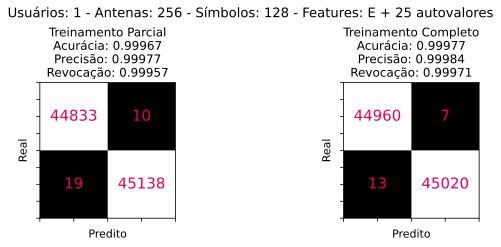

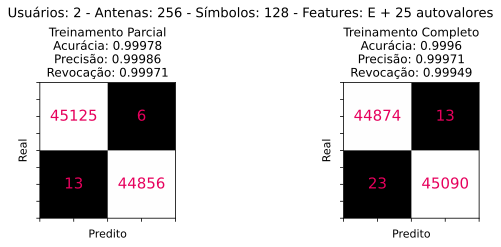

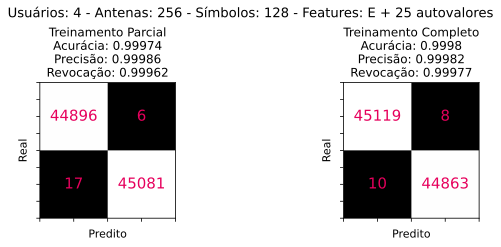

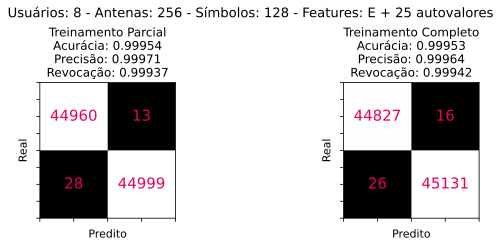

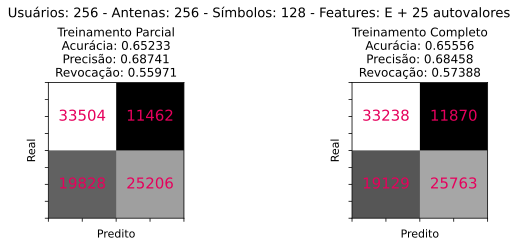

In [33]:
# PARA CADA QTD DE USUARIOS
for qtdUsuariosAtual in rangeQtdUsuarios:
    
    # OBTENHO OS DATASETS DESCRITOS ACIMA
    dataSNRsTreinamento, dataSNRsTeste, dataSNRsCompletas, targetSNRsTreinamento, targetSNRsTeste, targetSNRsCompletas = obterDatasetsDiferentesSNRs(qtdUsuariosAtual, qtdAntenas, qtdSimbolos, autovaloresIndesejados)
    
    # COMO O KFOLD VAI SER UM POUCO DIFERENTE, VOU FAZER DIRETO AQUI MSM, AS MATRIZES SAO REFERENTES AO CASO EM QUE O TREINAMENTO E COMPLETO, E O QUE O TREINAMENTO E PARCIAL (SNRS DE 5 EM 5)
    somaMatrizesConfusaoTreinamentoParcial  = np.zeros((2,2))
    somaMatrizesConfusaoTreinamentoCompleto = np.zeros((2,2))    
    
    # RODANDO O KFOLD
    objKFold = KFold(n_splits=qtdFolders, shuffle=True)
    for arrayIndexesTreinamento, arrayIndexesTeste in objKFold.split(dataSNRsCompletas):
        
        # CASO DO TREINAMENTO PARCIAL (5 EM 5 DB) E TESTE COM AS SNRS RESTANTES
        xTrain, xTest, yTrain, yTest = dataSNRsTreinamento[arrayIndexesTreinamento], dataSNRsTeste[arrayIndexesTeste], targetSNRsTreinamento[arrayIndexesTreinamento], targetSNRsTeste[arrayIndexesTeste]
        yPred = treinarEClassificar(xTrain, xTest, yTrain, classificador)
        somaMatrizesConfusaoTreinamentoParcial += confusion_matrix(yTest, yPred)
        
        # CASO DO TREINAMENTO COMPLETO (TODAS AS SNRS) E TESTE COMPLETO TAMBEM
        xTrain, xTest, yTrain, yTest = dataSNRsCompletas[arrayIndexesTreinamento], dataSNRsCompletas[arrayIndexesTeste], targetSNRsCompletas[arrayIndexesTreinamento], targetSNRsCompletas[arrayIndexesTeste]
        yPred = treinarEClassificar(xTrain, xTest, yTrain, classificador)
        somaMatrizesConfusaoTreinamentoCompleto += confusion_matrix(yTest, yPred)
        
    # PRINTAR
    printarComparacaoTreinamentoParcialECompleto(somaMatrizesConfusaoTreinamentoParcial, somaMatrizesConfusaoTreinamentoCompleto, qtdUsuariosAtual, qtdAntenas, qtdSimbolos, qtdAutovaloresDesejados)